## CIFAR 10

Classification (10 classes)

CIFAR 10 consists of: 60,000 tiny 32 x 32 color RGB images ## MNIST is 28 x 28 and not RGB

Labeled with Integer 1 to 10 classes 

Airplane (0), Car (1), etc. 

In [1]:
import torch
import imageio
import os

import matplotlib.pyplot as plt

import numpy as np
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms

import sklearn

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, accuracy_score, f1_score

import pandas as pd
from collections import Counter

In [2]:
data_path = 'data/cifar10data/'

cifar10 = datasets.CIFAR10(data_path, train = True, download = True)

Files already downloaded and verified


### Here, we download the CIFAR 10 data into the validation set

In [3]:
cifar10_val = datasets.CIFAR10(data_path, train = False, download = True)

Files already downloaded and verified


In [4]:
cifar10 = datasets.CIFAR10(data_path, train = True, download = False)

In [5]:
print(cifar10)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/cifar10data/
    Split: Train


In [6]:
img, label = cifar10[99]

label

1

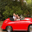

In [7]:
img

In [8]:
print( dir(transforms) )

['AugMix', 'AutoAugment', 'AutoAugmentPolicy', 'CenterCrop', 'ColorJitter', 'Compose', 'ConvertImageDtype', 'FiveCrop', 'GaussianBlur', 'Grayscale', 'InterpolationMode', 'Lambda', 'LinearTransformation', 'Normalize', 'PILToTensor', 'Pad', 'RandAugment', 'RandomAdjustSharpness', 'RandomAffine', 'RandomApply', 'RandomAutocontrast', 'RandomChoice', 'RandomCrop', 'RandomEqualize', 'RandomErasing', 'RandomGrayscale', 'RandomHorizontalFlip', 'RandomInvert', 'RandomOrder', 'RandomPerspective', 'RandomPosterize', 'RandomResizedCrop', 'RandomRotation', 'RandomSolarize', 'RandomVerticalFlip', 'Resize', 'TenCrop', 'ToPILImage', 'ToTensor', 'TrivialAugmentWide', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_pil_constants', '_presets', 'autoaugment', 'functional', 'functional_pil', 'functional_tensor', 'transforms']


In [9]:
print(img)
print("")

to_tensor = transforms.ToTensor()

img_t = to_tensor(img)

print(img_t.shape)

<PIL.Image.Image image mode=RGB size=32x32 at 0x7FCE95FA2280>

torch.Size([3, 32, 32])


### The 'transforms' attribute can be passed directly to the entire dataset

In [10]:
tensor_cifar10 = datasets.CIFAR10(data_path, train = True, download = False, transform = transforms.ToTensor())

In [11]:
img_t, _ = tensor_cifar10[99]

In [12]:
print(img_t)

tensor([[[0.2431, 0.1961, 0.1804,  ..., 0.6549, 0.7176, 0.5373],
         [0.2471, 0.2157, 0.2039,  ..., 0.6392, 0.6706, 0.5686],
         [0.2275, 0.2510, 0.2196,  ..., 0.6000, 0.5882, 0.4824],
         ...,
         [0.6745, 0.5608, 0.5098,  ..., 0.3686, 0.5529, 0.5451],
         [0.7176, 0.5882, 0.3137,  ..., 0.3176, 0.5294, 0.5608],
         [0.8196, 0.7137, 0.5451,  ..., 0.2314, 0.5098, 0.6627]],

        [[0.2510, 0.1961, 0.1725,  ..., 0.6745, 0.7216, 0.5333],
         [0.2549, 0.2078, 0.1961,  ..., 0.6627, 0.6824, 0.5725],
         [0.2431, 0.2588, 0.2353,  ..., 0.6078, 0.6039, 0.5020],
         ...,
         [0.5294, 0.4314, 0.2196,  ..., 0.2941, 0.4235, 0.4118],
         [0.5725, 0.4627, 0.2510,  ..., 0.2824, 0.4627, 0.4902],
         [0.6824, 0.5922, 0.4275,  ..., 0.2118, 0.4667, 0.6118]],

        [[0.1725, 0.1020, 0.0745,  ..., 0.2706, 0.2980, 0.2824],
         [0.1451, 0.1020, 0.1059,  ..., 0.2392, 0.2941, 0.3020],
         [0.1412, 0.1451, 0.1451,  ..., 0.2431, 0.2510, 0.

### This section depicts how to Normalize the data

In [13]:
imgs_s = [ img_t for img_t, _ in tensor_cifar10 ]
imgs = torch.stack(imgs_s, dim = 3)

print(imgs.shape)

torch.Size([3, 32, 32, 50000])


In [14]:
view1 = imgs.view(3, -1).mean(dim = 1)
print(view1)

tensor([0.4914, 0.4822, 0.4465])


In [15]:
view2 = imgs.view(3, -1).std(dim = 1)
print(view2)

tensor([0.2470, 0.2435, 0.2616])


In [16]:
transformed_cifar10 = datasets.CIFAR10(data_path, train = True, download = False, 
                                       transform = transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize(view1, view2)
                                         ]))

### Normalize and Converted to tensors for PyTorch - Train and Val sets

In [17]:
transformed_cifar10_val = datasets.CIFAR10(data_path, train = False, download = False, 
                                       transform = transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize(view1, view2)
                                         ]))

### Now, we build the dataset

In [18]:
label_map = {0:0, 2:1}

In [19]:
class_names = ['airplane', 'bird']

In [20]:
cifar2 = [ (img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]

In [21]:
cifar2_val = [ (img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]

### This section depicts the Softmax Function

In [22]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [23]:
x = torch.tensor([1.0, 2.0, 3.0])

In [24]:
print(softmax(x))

tensor([0.0900, 0.2447, 0.6652])


### Convert Vectors from 32 x 32 x 3 to 1 x 3072

In [25]:
n_out = 2

model_mlp = nn.Sequential(
    
    nn.Linear(3072, 512),
    nn.Tanh(),
    
    nn.Linear(512, n_out),
    nn.Softmax(dim = 1)
)

In [26]:
model_2DL = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.ReLU(),        ## nn.GeLU()
    
    nn.Linear(1024, 512),
    nn.ReLU(),
    
    nn.Linear(512, 128),
    nn.ReLU(),
    
    nn.Linear(128, 2),
    nn.LogSoftmax(dim = 1)
)

### Negative Log Likelihood Function

In [27]:
# loss_fn = nn.NLLLoss()

loss_fn = nn.CrossEntropyLoss()

### DataLoader

In [28]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)

In [29]:
## model_fn = model_mlp
model_fn = model_2DL

### The Training Process

In [30]:
learning_rate = 1e-2    #0.001
n_epochs = 100


## optimizer = optim.SGD(model_fn.parameters(), lr = learning_rate)
optimizer = optim.Adam( model_fn.parameters(), lr = learning_rate)

In [31]:
for epoch in range (n_epochs):
    for imgs, labels in train_loader:       ## imgs [64x3x32x32]
        
        ## resize for network
        batch_size = imgs.shape[0]
        imgs_resized = imgs.view(batch_size, -1)    ## imgs_resized [64x3072]
        
        outputs = model_fn(imgs_resized)
        
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(loss)
        
    

tensor(0.5140, grad_fn=<NllLossBackward0>)
tensor(0.5769, grad_fn=<NllLossBackward0>)
tensor(0.6829, grad_fn=<NllLossBackward0>)
tensor(0.6901, grad_fn=<NllLossBackward0>)
tensor(0.6893, grad_fn=<NllLossBackward0>)
tensor(0.6932, grad_fn=<NllLossBackward0>)
tensor(0.6893, grad_fn=<NllLossBackward0>)
tensor(0.6899, grad_fn=<NllLossBackward0>)
tensor(0.6991, grad_fn=<NllLossBackward0>)
tensor(0.6925, grad_fn=<NllLossBackward0>)
tensor(0.6919, grad_fn=<NllLossBackward0>)
tensor(0.7013, grad_fn=<NllLossBackward0>)
tensor(0.6956, grad_fn=<NllLossBackward0>)
tensor(0.6911, grad_fn=<NllLossBackward0>)
tensor(0.6934, grad_fn=<NllLossBackward0>)
tensor(0.6886, grad_fn=<NllLossBackward0>)
tensor(0.6917, grad_fn=<NllLossBackward0>)
tensor(0.6859, grad_fn=<NllLossBackward0>)
tensor(0.7070, grad_fn=<NllLossBackward0>)
tensor(0.6901, grad_fn=<NllLossBackward0>)
tensor(0.6932, grad_fn=<NllLossBackward0>)
tensor(0.7022, grad_fn=<NllLossBackward0>)
tensor(0.6905, grad_fn=<NllLossBackward0>)
tensor(0.68

## After training, now we test the values

In [32]:
val_loader = torch.utils.data.DataLoader( cifar2_val, batch_size = 64, shuffle = False )

temp_metric = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model_fn( imgs.view(batch_size, -1) )
        
        # print('Size of Matrix: ', outputs.shape)
        # print(labels.shape)
        
        _ , pred = torch.max( outputs, dim = 1 )    ## dim = 1 causes a horizontal search, whereas dim = 0 causes a vertical search
        
        temp_metric = temp_metric + int( (pred == labels).sum() )
        total = total + batch_size
        
print (temp_metric/total)

0.5


In [33]:
def print_stats_percentage_train_test( algorithm_name, y_test, y_pred):    
     print("------------------------------------------------------")
     print("------------------------------------------------------")
    
     print("The Algorithm is: ", algorithm_name)
        
     print('Accuracy: %.2f' % accuracy_score(y_test,   y_pred) )
     
     confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
     print("Confusion matrix: ")
     print(confmat)
     print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
     print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
     print('F1-measure: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='weighted'))

In [34]:
print_stats_percentage_train_test("2DL", labels, pred)

------------------------------------------------------
------------------------------------------------------
The Algorithm is:  2DL
Accuracy: 0.44
Confusion matrix: 
[[0 9]
 [0 7]]
Precision: 0.191
Recall: 0.438
F1-measure: 0.266


/opt/miniconda3/envs/ITS5200/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
